In [7]:
import os
import numpy as np
import pandas as pd

import joblib
import mlflow
from mlflow.tracking import MlflowClient
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, classification_report
import matplotlib.pyplot as plt


In [10]:
MLRUNS_DIR = (Path("..") / "mlruns").resolve()
mlflow.set_tracking_uri(MLRUNS_DIR.as_uri())
print("MLflow tracking URI:", mlflow.get_tracking_uri())
print("Exists:", MLRUNS_DIR.exists())

client = MlflowClient()


MLflow tracking URI: file:///Users/seecsy/ai_project_method/mlruns
Exists: True


In [13]:
EXP_NAME = "Churn_Project"
exp = client.get_experiment_by_name(EXP_NAME)

if exp is None:
    raise ValueError(f"Experiment '{EXP_NAME}' not found. Check MLflow UI / experiment name.")

print("Experiment:", exp.name)
print("Experiment ID:", exp.experiment_id)
print("Artifact location:", exp.artifact_location)

runs = client.search_runs(
    experiment_ids=[exp.experiment_id],
    order_by=["attributes.start_time DESC"],
    max_results=50
)

print("Runs found:", len(runs))
for r in runs[:5]:
    print(r.info.run_id, r.data.metrics)


Experiment: Churn_Project
Experiment ID: 590222640008089693
Artifact location: file:///Users/seecsy/ai_project_method/mlruns/590222640008089693
Runs found: 4
dc5f8b9363c14b2bbba05a1051610c93 {'accuracy': 0.872113676731794, 'recall': 0.4631578947368421, 'precision': 0.676923076923077, 'f1': 0.55}
7685cafbdad94e36865d7573a5a099b2 {'accuracy': 0.8854351687388987, 'recall': 0.5105263157894737, 'precision': 0.7293233082706767, 'f1': 0.6006191950464397}
4f7b641c78b94b42b23f0d1bf9f7650d {'accuracy': 0.88898756660746, 'recall': 0.5105263157894737, 'precision': 0.751937984496124, 'f1': 0.6081504702194357}
794e7037861c462da94515dca2b74b18 {'accuracy': 0.88898756660746, 'recall': 0.5105263157894737, 'precision': 0.751937984496124, 'f1': 0.6081504702194357}


In [14]:
rows = []
for r in runs:
    m = r.data.metrics
    p = r.data.params
    rows.append({
        "run_id": r.info.run_id,
        "start_time": r.info.start_time,
        "accuracy": m.get("accuracy"),
        "f1": m.get("f1"),
        "precision": m.get("precision"),
        "recall": m.get("recall"),
        "max_iter": p.get("max_iter"),
        "model": p.get("model"),
        "test_size": p.get("test_size"),
        "random_state": p.get("random_state"),
    })

df_runs = pd.DataFrame(rows).sort_values(by="f1", ascending=False)
df_runs


,run_id,start_time,accuracy,f1,precision,recall,max_iter,model,test_size,random_state
2,4f7b641c78b94b42b23f0d1bf9f7650d,1766502783331,0.888988,0.608150,0.751938,0.510526,10000,LogisticRegression,0.2,42
3,794e7037861c462da94515dca2b74b18,1766502735504,0.888988,0.608150,0.751938,0.510526,10000,LogisticRegression,0.2,42
1,7685cafbdad94e36865d7573a5a099b2,1766503047321,0.885435,0.600619,0.729323,0.510526,1000,LogisticRegression,0.2,42
0,dc5f8b9363c14b2bbba05a1051610c93,1766503082580,0.872114,0.550000,0.676923,0.463158,500,LogisticRegression,0.2,42


In [15]:
best = df_runs.iloc[0]
best_run_id = best["run_id"]
print("Best run:", best_run_id)
best


Best run: 4f7b641c78b94b42b23f0d1bf9f7650d


run_id          4f7b641c78b94b42b23f0d1bf9f7650d
start_time                         1766502783331
accuracy                                0.888988
f1                                       0.60815
precision                               0.751938
recall                                  0.510526
max_iter                                   10000
model                         LogisticRegression
test_size                                    0.2
random_state                                  42
Name: 2, dtype: object

In [16]:
model_uri = f"runs:/{best_run_id}/model"
best_model = mlflow.sklearn.load_model(model_uri)
best_model


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [17]:
PROC_PATH = "../data/processed/churn_processed.csv"
TARGET = "Churn"

df = pd.read_csv(PROC_PATH)
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pred = best_model.predict(X_test)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.91      0.97      0.94       936
           1       0.75      0.51      0.61       190

    accuracy                           0.89      1126
   macro avg       0.83      0.74      0.77      1126
weighted avg       0.88      0.89      0.88      1126



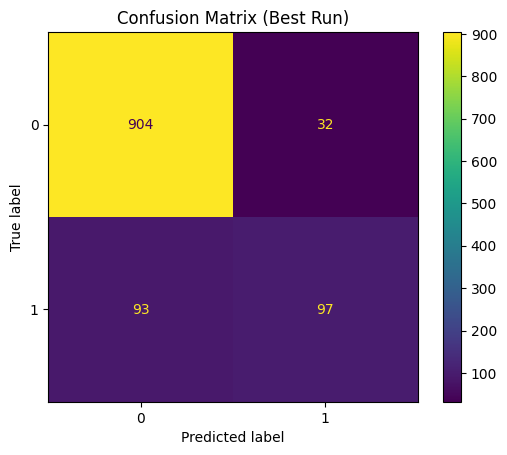

In [18]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix (Best Run)")
plt.show()


ROC AUC: 0.8846547458389563


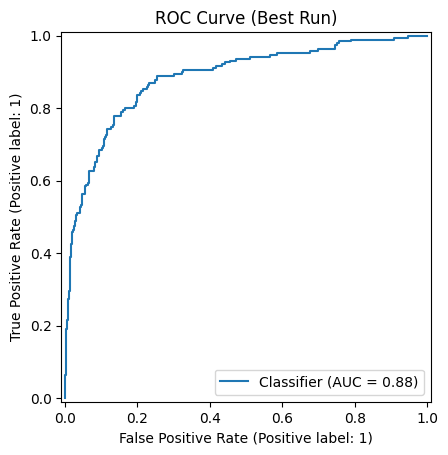

In [19]:
if hasattr(best_model, "predict_proba"):
    proba = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, proba)
    print("ROC AUC:", auc)
    RocCurveDisplay.from_predictions(y_test, proba)
    plt.title("ROC Curve (Best Run)")
    plt.show()
else:
    print("Model does not support predict_proba; skipping ROC.")
